## 인물사진을 만들어 보자 📸

#### [목차]
[1. 인물모드 사진 만들기](#1.-인물모드-사진-만들기) \
[1.1 사람 1명](#1.1-사람-1명) \
[1.2 사람 2명](#1.2-사람-2명) \
[1.3 사람 1명, 강아지 1마리, 자전거 1대](#1.3-사람-1명,-강아지-1마리,-자전거-1대) \
[2. 두 이미지 합성하기](#2.-두-이미지-합성하기) \
[2.1 도시 한복판에 나타난 고양이(크로마 키 마스킹과 합성)](#2.1-도시-한복판에-나타난-고양이(크로마-키-마스킹과-합성)) \
[3. 인물사진에서의 문제점 및 해결책](#3.-인물사진에서의-문제점-및-해결책) \
[3.1 문제점 확인 및 해결책 제안](#3.1-문제점-확인-및-해결책-제안) \
[3.2 해결책 적용하기](#3.2-해결책-적용하기) \
[4. 이것도 해보자](#4.-이것도-해보자) \
[4.1 영상 배경 바꾸기](#4.1-영상-배경-바꾸기) \
[4.2 결과 확인](#4.2-결과-확인) \
[5. 회고](#5.-회고) 

In [1]:
import os
import urllib  # 웹에서 데이터를 다운로드할 때 사용
import cv2  #  OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation  # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt
from pixellib.tune_bg import alter_bg

### 1. 인물모드 사진 만들기

### 1.1 사람 1명

### 1.1.1 이미지 불러오기

(904, 750, 3)


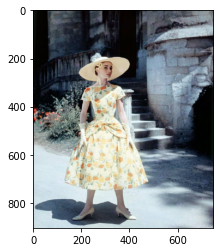

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 1.1.2 시맨틱 세그멘테이션으로 분리하기

In [3]:
# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f335c2881f0>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

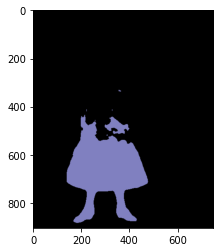

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [6]:
plt.imshow(output)
plt.show()
segvalues

In [7]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [9]:
# 물체마다 output에 어떤 색상으로 나타나 있는지 확인
# 사람을 나타내는 15번째 색상
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15]

array([192, 128, 128])

In [10]:
# 색상 값 순서 바꾸기(RGB→BGR)
seg_color = (128,128,192)

(904, 750)


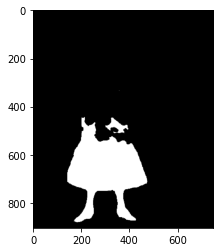

In [11]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

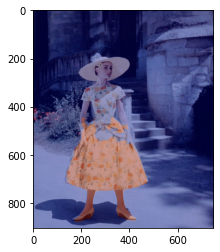

In [12]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1.1.3 배경 흐리게 하기

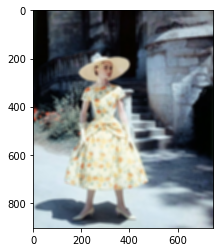

In [13]:
# (13,13)은 blurring kernel size를 뜻한다.

img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

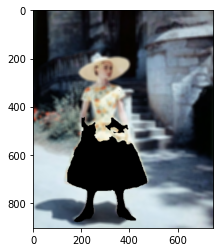

In [14]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1.1.4 흐린 배경과 원본 이미지 합성

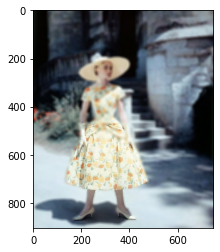

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1.2 사람 2명

### 1.2.1 이미지 불러오기

(680, 680, 3)


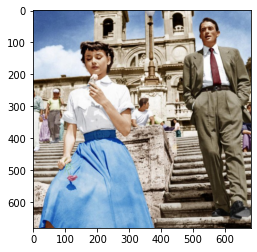

In [16]:
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.png'  
img1_orig = cv2.imread(img1_path)

print(img1_orig.shape)
plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 1.2.2 시맨틱 세그멘테이션으로 분리하기

In [17]:
# 모델에 이미지 입력
segvalues1, output1 = model.segmentAsPascalvoc(img1_path)

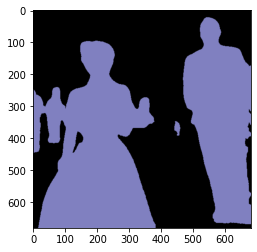

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [18]:
plt.imshow(output1)
plt.show()
segvalues1

In [19]:
for class_id in segvalues1['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [20]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15]

array([192, 128, 128])

In [21]:
# 색상 값 순서 바꾸기(RGB→BGR)
seg_color = (128,128,192)

(680, 680)


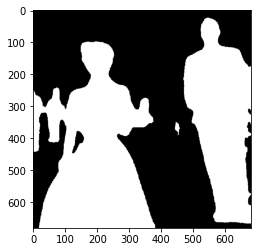

In [22]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg_map = np.all(output1==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

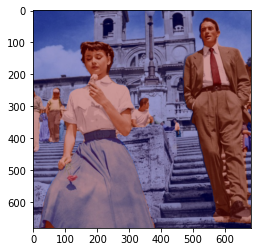

In [23]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img1_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1.2.3 배경 흐리게 하기

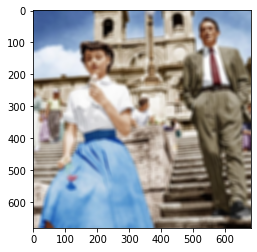

In [24]:
# (13,13)은 blurring kernel size를 뜻한다.

img1_orig_blur = cv2.blur(img1_orig, (13,13))  
plt.imshow(cv2.cvtColor(img1_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

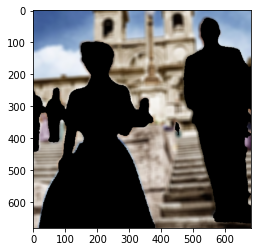

In [25]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img1_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1.2.4 흐린 배경과 원본 이미지 합성

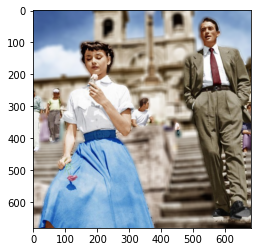

In [26]:
img_concat = np.where(img_mask_color==255, img1_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1.3 사람 1명, 강아지 1마리, 자전거 1대

### 1.3.1 이미지 불러오기

(524, 699, 3)


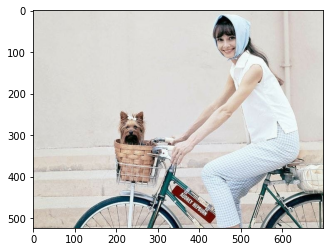

In [27]:
img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.png'  
img2_orig = cv2.imread(img2_path)

print(img2_orig.shape)
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 1.3.2 시맨틱 세그멘테이션으로 분리하기

In [28]:
# 모델에 이미지 입력
segvalues2, output2 = model.segmentAsPascalvoc(img2_path)

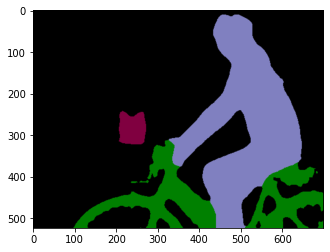

{'class_ids': array([ 0,  2, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [29]:
plt.imshow(output2)
plt.show()
segvalues2

In [30]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle
dog
person


In [31]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print('자전거 색상:', colormap[2])
print('강아지 색상:', colormap[12])
print('사람 색상:', colormap[15])

자전거 색상: [  0 128   0]
강아지 색상: [ 64   0 128]
사람 색상: [192 128 128]


In [32]:
# 색상 값 순서 바꾸기(RGB→BGR)
seg2_color = (0, 128, 0)
seg12_color = (128, 0, 64)
seg15_color = (128, 128, 192)

(524, 699)


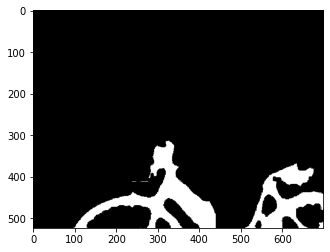

(524, 699)


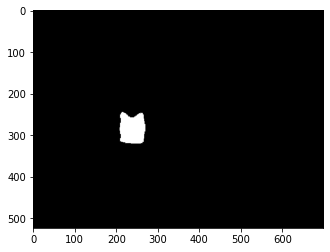

(524, 699)


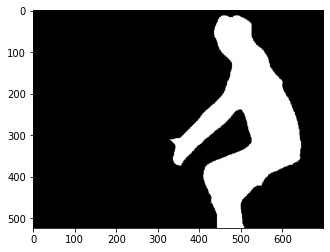

In [33]:
# seg_color로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다.
seg2_map = np.all(output2==seg2_color, axis=-1)
seg12_map = np.all(output2==seg12_color, axis=-1)
seg15_map = np.all(output2==seg15_color, axis=-1)

print(seg2_map.shape)
plt.imshow(seg2_map, cmap='gray')
plt.show()

print(seg12_map.shape)
plt.imshow(seg12_map, cmap='gray')
plt.show()

print(seg15_map.shape)
plt.imshow(seg15_map, cmap='gray')
plt.show()

(524, 699)


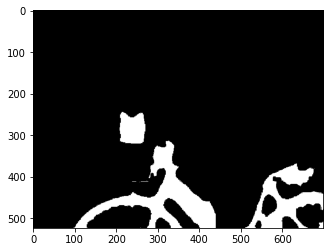

(524, 699)


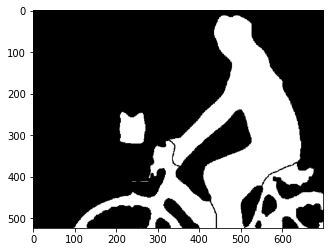

In [34]:
seg_map_sum = np.bitwise_or(seg2_map, seg12_map)
print(seg_map_sum.shape)
plt.imshow(seg_map_sum, cmap='gray')
plt.show()

seg_map_final = np.bitwise_or(seg_map_sum, seg15_map)
print(seg_map_final.shape)
plt.imshow(seg_map_final, cmap='gray')
plt.show()

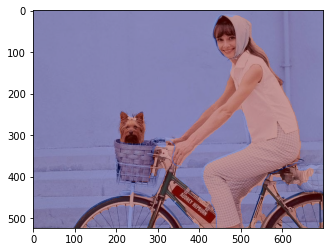

In [35]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img2_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map_final.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1.3.3 배경 흐리게 하기

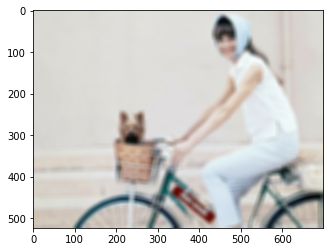

In [36]:
# (13,13)은 blurring kernel size를 뜻한다.

img2_orig_blur = cv2.blur(img2_orig, (13,13))  
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

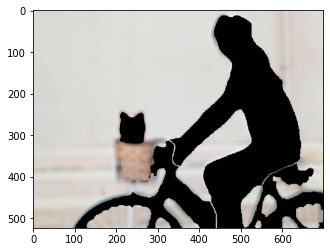

In [37]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img2_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1.3.4 흐린 배경과 원본 이미지 합성

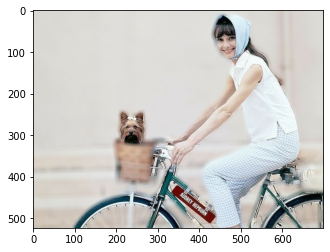

In [38]:
img_concat = np.where(img_mask_color==255, img2_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 두 이미지 합성하기

### 2.1 도시 한복판에 나타난 고양이🐱 (크로마 키 마스킹과 합성)

* 참고 : \
https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0

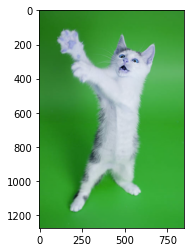

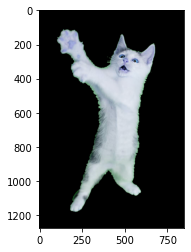

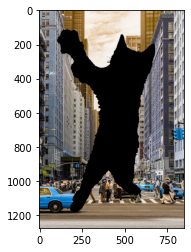

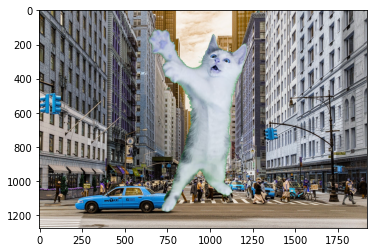

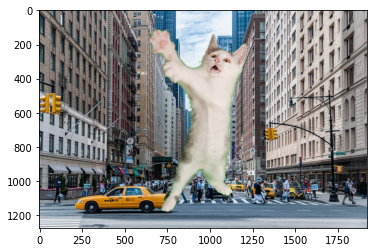

In [39]:
# 크로마키 영상과 합성할 이미지 불러오기
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img1 = cv2.imread(cat_path)
city_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/city.png'  
img2 = cv2.imread(city_path)

# ROI 선택을 위한 좌표 계산 (가운데에 위치하기 위한)
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

x = (width2 - width1) // 2
y = height2 - height1
w = x + width1
h = y + height1

# 크로마키 배경 영상에서 크로마키가 있을 법한 영역을 10픽셀 정도로 지정
chromakey = img1[:5, :5, :] # (0,0)~(10,10)까지의 정사각형 좌표
offset = 20 # 임의의 값

# 크로마키 영역과 이미지 전체를 HSV로 변경
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

# 크로마키 영역의 H 값에서 offset 만큼 여유를 두어 범위 지정
chroma_h = hsv_chroma[:, :, 0] # 크로마키의 H 값 (초록색 또는 파란색)
lower = np.array([chroma_h.min()-offset, 100, 100]) # 크로마키의 최소 범위
upper = np.array([chroma_h.max()+offset, 255, 255]) # 크로마키의 최대 범위

# 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)   # 고양이는 픽셀 0 (검정색)
mask_inv = cv2.bitwise_not(mask)            # 배경은 픽셀 0 (검정색) mask의 반전
roi = img2[y:h, x:w]                        # 배경에서의 관심영역 (가운데)
fg = cv2.bitwise_and(img1, img1, mask=mask_inv) # 고양이만 떼내기
bg = cv2.bitwise_and(roi, roi, mask=mask)       # 배경만 떼내기
img2[y:h, x:w] = fg + bg                        # 고양이만 + 배경만 (합성)

# 결과 출력
plt.imshow(img1)
plt.show()

plt.imshow(fg)
plt.show()

plt.imshow(bg)
plt.show()

plt.imshow(img2)
plt.show()

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 인물사진에서의 문제점 및 해결책

### 3.1 문제점 확인 및 해결책 제안

### 3.1.1  사람 1명

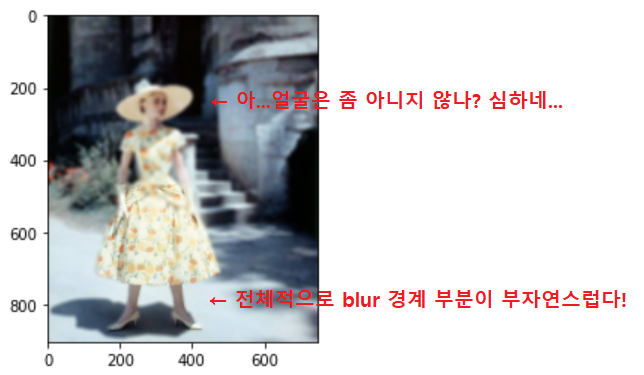

* blur처리가 되지 말아야 할 부분(얼굴 및 상체)까지 blur 처리가 된 점
  **→ 사람을 더 잘 detection 할 수 있는 모델로 바꾼다.**
* 전체적인 blur 겅계 부분이 부자연스러운 점
  **→ 경계 부분이 부드러워질 수 있도록 GaussianBlur를 사용한다.**

### 3.1.2 사람 2명

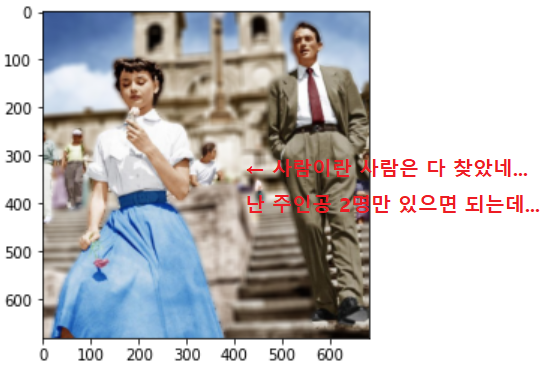

* blur처리가 되지 말아야 할 부분(얼굴 및 상체)까지 blur 처리가 된 점
  **→ 사람을 개별적으로 detection 할 수 있는 모델로 바꾼다.**

### 3.1.3 사람 1명, 강아지 1마리, 자전거 1대

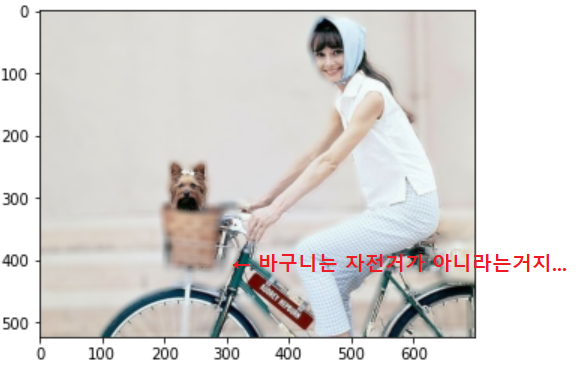

* 바구니까지 blur 처리가 된 점
  **→ 더 많은 dataset으로 훈련된 모델로 바꾼다.**

### 3.2 해결책 적용하기

In [40]:
!pip3 install pycocotools

     |████████████████████████████████| 106 kB 7.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp39-cp39-linux_x86_64.whl size=103779 sha256=15d922e8f1375793373ce044f28b54ad9bb9bc5acfd49f52e88e896c821bb570
  Stored in directory: /aiffel/.cache/pip/wheels/7e/b0/8e/f2c3593944ead79f5146d057d1310ee6d7b60d30b826779846
Successfully built pycocotools


In [41]:
!pip3 install pixellib

In [42]:
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

### 3.2.1 사람 1명

* 사람은 더 잘 detection하기 위해 [PointRend Instance Segmentation](https://github.com/ayoolaolafenwa/PixelLib/blob/master/Tutorials/Pytorch_image_instance_segmentation.md)모델을 사용한다.
* https://openaccess.thecvf.com/content_CVPR_2020/papers/Kirillov_PointRend_Image_Segmentation_As_Rendering_CVPR_2020_paper.pdf
* blur의 경계 부분을 자연스럽게 해주기 위해 [GaussianBlur](https://mangastorytelling.tistory.com/entry/%EB%B9%B5%ED%98%95%EC%9D%98-%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD-%EC%95%84%EC%9D%B4%ED%8F%B0-%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84-%EB%AA%A8%EB%93%9C-%EB%94%B0%EB%9D%BC-%EB%A7%8C%EB%93%A4%EA%B8%B0-Python-Deep-Learning)를 사용한다.

In [43]:
# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'pointrend_resnet101.pkl')

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.png'  
img_orig = cv2.imread(img_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
target_classes = ins.select_target_classes(person = True)
results, output = ins.segmentImage(img_path, segment_target_classes = target_classes, extract_from_box = True, 
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


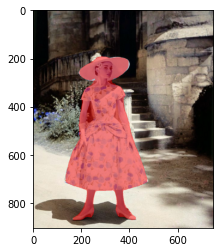

{'boxes': array([[135, 180, 474, 877]]),
 'class_ids': array([0]),
 'class_names': ['person'],
 'object_counts': Counter({'person': 1}),
 'scores': array([99]),
 'masks': array([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        ...,
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]]),
 'extracted_objects': [array([[[ 52,  38,  26],
          [ 51,  

In [44]:
plt.imshow(output)
plt.show()
results

(904, 750)


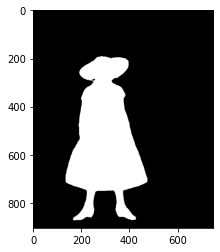

In [45]:
seg_map = np.all(results['masks']==True, axis=-1)

print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

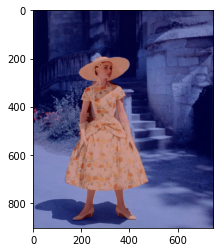

In [46]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

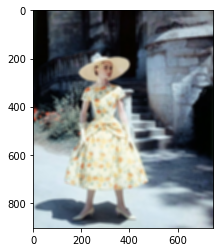

In [47]:
# (13,13)은 blurring kernel size를 뜻한다.

img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

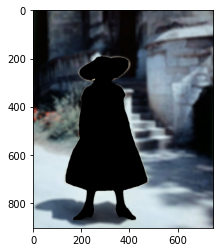

In [48]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

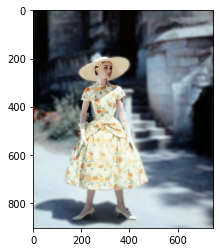

In [49]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [50]:
# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

In [51]:
print(img_mask.shape)
print(img_mask_3C.shape)
print(img_Gmask.shape)

(904, 750)
(904, 750, 3)
(904, 750, 3)


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_te

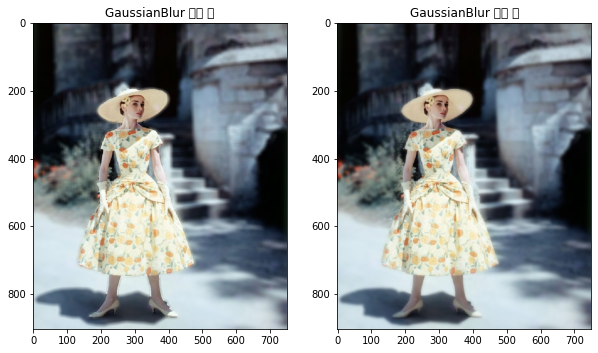

In [52]:
plt.figure(figsize=(10, 10))

ax = plt.subplot(121)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('GaussianBlur 적용 전')

ax = plt.subplot(122)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
ax.set_title('GaussianBlur 적용 후')
plt.show()

* 모델(PointRend Instance Segmentation)을 바꿈으로써 blur처리됐던 상체를 제대로 detection 할 수 있었다.
* GaussianBlur를 통해 경계 부분을 이전보다 더 자연스럽게 만들어낼 수 있었다.

### 3.2.2 사람 2명

* 사람을 각각 인식하기 위해 [PointRend Instance Segmentation](https://github.com/ayoolaolafenwa/PixelLib/blob/master/Tutorials/Pytorch_image_instance_segmentation.md)모델을 사용한다.

In [53]:
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.png'  
img1_orig = cv2.imread(img1_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
results1, output1 = ins.segmentImage(img1_path, extract_from_box = True, # 박스는 필요없으므로 삭제
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


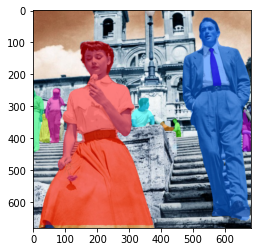

{'boxes': array([[463,  24, 677, 657],
        [ 15,  90, 376, 674],
        [549, 119, 587, 238],
        [ 34, 244, 102, 415],
        [306, 272, 379, 366],
        [  0, 243,  35, 446],
        [432, 338, 461, 397],
        [396, 347, 440, 377],
        [649, 306, 679, 441],
        [ 16, 307,  54, 416]]),
 'class_ids': array([ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0]),
 'class_names': ['person',
  'person',
  'tie',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person'],
 'object_counts': Counter({'person': 9, 'tie': 1}),
 'scores': tensor([99, 99, 99, 99, 99, 98, 97, 84, 65, 51]),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
      

In [54]:
plt.imshow(output1)
plt.show()
results1

* 넥타이는 빼고 사람만 인식할 수 있도록 변경

In [55]:
# 저장할 파일 이름 결정
img1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.png'  
img1_orig = cv2.imread(img1_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
target_classes = ins.select_target_classes(person = True)
results1, output1 = ins.segmentImage(img1_path, segment_target_classes = target_classes, extract_from_box = True, 
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


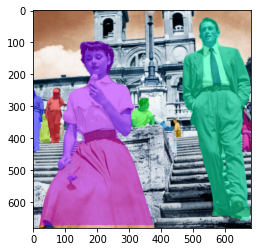

{'boxes': array([[463,  24, 677, 657],
        [ 15,  90, 376, 674],
        [ 34, 244, 102, 415],
        [306, 272, 379, 366],
        [  0, 243,  35, 446],
        [432, 338, 461, 397],
        [396, 347, 440, 377],
        [649, 306, 679, 441],
        [ 16, 307,  54, 416]]),
 'class_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'class_names': ['person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person'],
 'object_counts': Counter({'person': 9}),
 'scores': array([99, 99, 99, 99, 98, 97, 84, 65, 51]),
 'masks': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False

In [56]:
plt.imshow(output1)
plt.show()
results1

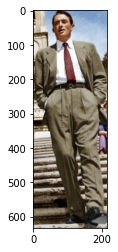

In [57]:
men = results1["extracted_objects"][0]
plt.imshow(cv2.cvtColor(men, cv2.COLOR_BGR2RGB))
plt.show()

In [58]:
print(results1['masks'].shape)
print(results1['masks'].ndim)

(680, 680, 9)
3


In [59]:
men = results1['masks'][:,:,0]

In [60]:
men = np.reshape(men,(680,680,1,-1))

(680, 680, 1)


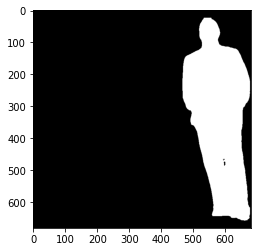

In [61]:
seg_map1 = np.all(men==True, axis=-1)

print(seg_map1.shape)
plt.imshow(seg_map1, cmap='gray')
plt.show()

In [62]:
women = results1['masks'][:,:,1]

In [63]:
women = np.reshape(women,(680,680,1,-1))

(680, 680, 1)


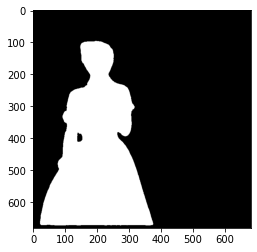

In [64]:
seg_map2 = np.all(women==True, axis=-1)

print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

(680, 680, 1)


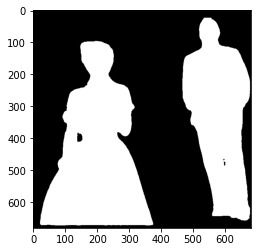

In [65]:
seg_map = np.bitwise_or(seg_map1, seg_map2)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

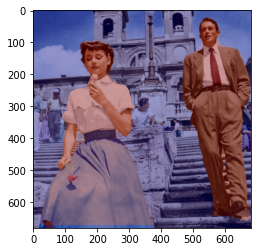

In [66]:
# 원래 이미지와 겹쳐서 확인하기
img_show = img1_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔준다.
img1_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask1 = cv2.applyColorMap(img1_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐준다.
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

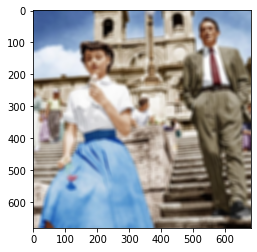

In [67]:
# (13,13)은 blurring kernel size를 뜻한다.

img1_orig_blur = cv2.blur(img1_orig, (13,13))  
plt.imshow(cv2.cvtColor(img1_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

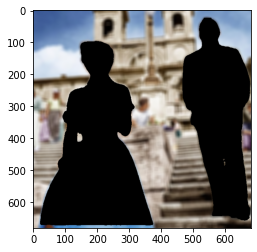

In [68]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img1_mask_color = cv2.cvtColor(img1_mask, cv2.COLOR_GRAY2BGR)
img1_bg_mask = cv2.bitwise_not(img1_mask_color)
img1_bg_blur = cv2.bitwise_and(img1_orig_blur, img1_bg_mask)
plt.imshow(cv2.cvtColor(img1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

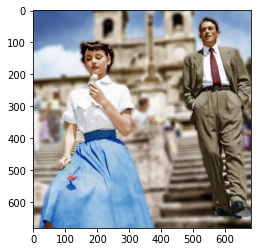

In [69]:
img1_concat = np.where(img1_mask_color==255, img1_orig, img1_bg_blur)
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 모델(PointRend Instance Segmentation)을 바꿈으로써 원하는 사람만 남기고 blur처리를 할 수 있었다.

### 3.2.3 사람 1명, 강아지 1마리, 자전거 1대

In [70]:
# 저장할 파일 이름 결정
img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.png'  
img2_orig = cv2.imread(img1_path)

ins = instanceSegmentation()
ins.load_model(model_file, network_backbone="resnet101")
results2, output2 = ins.segmentImage(img2_path, extract_from_box = True, 
                                    extract_segmented_objects=True, save_extracted_objects=True)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


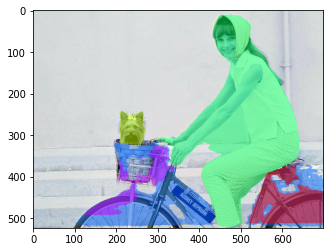

{'boxes': array([[299,   6, 643, 521],
        [ 97, 310, 699, 521],
        [202, 241, 271, 325],
        [491, 357, 695, 513],
        [110, 309, 356, 492]]),
 'class_ids': array([ 0,  1, 16,  1,  1]),
 'class_names': ['person', 'bicycle', 'dog', 'bicycle', 'bicycle'],
 'object_counts': Counter({'person': 1, 'bicycle': 3, 'dog': 1}),
 'scores': tensor([99, 99, 98, 53, 52]),
 'masks': array([[[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, Fa

In [71]:
plt.imshow(output2)
plt.show()
results2

* 변경한 모델(PointRend Instance Segmentation)은 COCO data set으로 학습한 모델이다.
* COCO dataset object에도 바구니는 들어가 있지 않다. ([하단] 참고)
* 따라서 변경한 모델에서도 바구니를 인식하지 못 하며, 학습된 다양한 모델을 찾아봤으나 바구니를 학습한 모델을 찾을 수 없었다.
* 이를 해결하기 위해서는 바구니에 대해 모델을 직접 학습([전이학습](https://ichi.pro/ko/pytorcheseo-deeplabv3leul-sayonghan-bunhal-eul-wihan-jeon-i-hagseub-272062660569666), [모델 커스텀](https://hansonminlearning.tistory.com/16))을 하는 방법이 있다.
* 이 방법은 시간도 많이 걸리고 데이터를 만들어야 하는 과정이 필요하므로 이번에는 진행하지 않는다. 

In [72]:
# [하단] COCO model 데이터의 라벨 종류
LABEL_NAMES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic_light', 
    'fire_hydrant', 'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 
    'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports_ball', 'kite', 'baseball_bat', 'baseball_glove', 'skateboard', 'surfboard', 'tennis_racket',
    'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot_dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted_plant', 'bed',
    'dining_table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell_phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy_bear', 'hair_dryer',
    'toothbrush'
]

### 4. 이것도 해보자😁

* Pixlib의 경우 모델 내부적으로 배경을 바꿔주는 기능이 들어있어 영상의 배경 또한 바꿀 수 있다.

### 4.1 영상 배경 바꾸기

In [74]:
model_dir1 = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir1, 'xception_pascalvoc.pb')

sun_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'
sun_file = os.path.join(sun_dir, 'sun.jpg')
coffee_file = os.path.join(sun_dir, 'coffee.mp4')

change_bg = alter_bg(model_type="pb")
change_bg.load_pascalvoc_model(model_file)

output = change_bg.change_video_bg(coffee_file, sun_file, frames_per_second = 10, output_video_name="output_video.mp4", detect = "person")

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

### 4.2 결과 확인

In [75]:
# VideoFileClip 은 비디오 파일을 읽어올 때 사용되는 클래스 
from moviepy.editor import VideoFileClip
# ipython_display() 는 동영상을 주피터 노트북에 렌더링할 수 있게 도와주는 함수
from moviepy.editor import ipython_display

# 클라우드 주피터 상에서 결과 동영상 출력하기
# 저장한 결과 영상파일(mp4) 불러오기
video_path = os.getenv('HOME')+'/aiffel/output_video.mp4' # 결과 영상
clip = VideoFileClip(video_path)
clip = clip.resize(width=640)
clip.ipython_display(fps=30, loop=True, autoplay=True, rd_kwargs=dict(logger=None))

* 아무래도 움직이는 영상이다보니 인물이 깔끔하게 잘려서 적용되지는 않는다.

### 5. 회고

### 5.1 어려웠던 점

* 모델을 다른 모델로 바꿔서 사용하면서 발생하는 에러들을 해결하는데 시간이 많이 걸렸다.
* 마스크를 딸 때 color map이 아닌 다른 방법을 찾는 것이 어려웠다.

### 5.2 알게된 점

* [np.bitwise_or](https://velog.io/@oosiz/OpenCV-Python-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B9%84%ED%8A%B8%EC%97%B0%EC%82%B0) : 두 이미지 중 하나에서만 흰색이여도 그 부분을 흰색으로 출력
* Gaussian Blurring : 가우시안 분포를 갖는 커널로 블러링 하는 것을 가우시안 블러링이라고 한다. 가우시안 블러링 커널은 아래와 같이 중앙값이 가장 크고 중앙에서 멀어질수록 그 값이 작아진다.  가우시안 블러링 커널을 적용하면 대상 픽셀에 가까울수록 많은 영향을 주고, 멀어질수록 적은 영향을 주기 때문에 원래의 영상과 비슷하면서도 노이즈를 제거하는 효과가 있다. `cv2.GaussianBlur()` 함수는 커널 크기와 표준 편차를 전달하면 가우시안 블러링을 적용해준다. `sigmaX`에 0을 전달하면 자동으로 표준편차를 선택해서 사용하고, `sigmaY`를 생략하면 `sigmaX` 값과 동일하게 적용한다.
* [COCO dataset](https://cocodataset.org/#home) : 객체 탐지 (object detection), 세그먼테이션 (segmentation), 키포인트 탐지 (keypoint detection) 등의 컴퓨터 비전(computer vision) 분야의 task를 목적으로 만들어진 데이터셋
* COCO dataset 추가 자료 : https://comlini8-8.tistory.com/67
* [Panoptic segmentation](https://ydy8989.github.io/2021-03-11-panoptic/) : Instance segmentation은 배경에는 관심이 없고, 움직이는 작업 물체에 대해서만 segmentation을 진행했다. 하지만, panoptic segmentation의 경우, 이미지 내 모든 부분에 대하여 segmentation을 진행하는 구조이다.
* Instance Segmentation by Deep Coloring \
https://arxiv.org/pdf/1807.10007.pdf \
https://github.com/kulikovv/DeepColoring
* [LVIS: A Dataset for Large Vocabulary Instance Segmentation](https://arxiv.org/pdf/1908.03195.pdf) : 페이스북에서 공개한 대규모 Instance Segmentation을 위한 데이터셋, 그 과정에 대한 논문에서는 매우 높은 품질의 데이터를 얻기 위한 방법을 엿볼 수 있다.

### 5.3 시도한 것들

* 새로운 모델들을 가져와 Instance Segmentation을 적용시켜 봄.

### 5.4 자기다짐

* Exploration을 진행하면서 항상 느끼는 것이지만 스스로 찾아서 공부하는 것이 머릿속에 오래 남아있는 것 같다.
* 그래서 Exploration을 진행할 때는 항상 많은 것을 찾아보고 적용시켜 보게 된다.
* 남아있는 것들도 이것저것 찾아보면서 머릿속에 남는 공부를 진행해 보고 싶다.

* seg_map_final = np.bitwise_or(seg_map_sum, seg15_map) \
https://numpy.org/doc/stable/reference/generated/numpy.bitwise_or.html
* 고양이 이미지 출처 \
https://www.istockphoto.com/kr
* 영상 출처 \
https://pixabay.com/ko/videos/search/
* GaussianBlur 추가 참고 자료 \
https://bkshin.tistory.com/entry/OpenCV-17-%ED%95%84%ED%84%B0Filter%EC%99%80-%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98Convolution-%EC%97%B0%EC%82%B0-%ED%8F%89%EA%B7%A0-%EB%B8%94%EB%9F%AC%EB%A7%81-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%AF%B8%EB%94%94%EC%96%B8-%EB%B8%94%EB%9F%AC%EB%A7%81-%EB%B0%94%EC%9D%B4%EB%A0%88%ED%84%B0%EB%9F%B4-%ED%95%84%ED%84%B0
* 공개 데이터셋 \
https://blog.naver.com/PostView.nhn?blogId=jws2218&logNo=221930525326&parentCategoryNo=&categoryNo=17&viewDate=&isShowPopularPosts=false&from=postView